# 0. Import packages and load data

In [1]:
import warnings
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 100)

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from yellowbrick.cluster import SilhouetteVisualizer
# load data
df_fin = pd.read_csv('financial_statements.csv')
df_daily = pd.read_feather('security_daily.ftr')


In [2]:
# view data

df_fin

,datadate_x,tic,name,gsector,market_cap,PBR,PER,EPS,ROE,net_income,net_cash_flow,volatility
0,20210104,PNW,PINNACLE WEST CAPITAL CORP,utilities,8.905297e+09,1.099,18.112,5.63,0.082,550.559,49.685,0.016509
1,20210104,ABT,ABBOTT LABORATORIES,health_care,1.933824e+11,6.183,96.174,1.89,0.107,4473.000,2907.000,0.013776
2,20210104,ALK,ALASKA AIR GROUP INC,industrial,6.089215e+09,1.627,10.233,-5.64,-0.145,-1324.000,1154.000,0.035188
3,20210104,MATX,MATSON INC,industrial,2.442149e+09,1.944,20.084,2.86,0.107,193.100,-8.700,0.030216
4,20210104,Y,ALLEGHANY CORP,financial,8.430382e+09,1.005,26.306,-1.75,-0.003,101.754,-411.621,0.021499
...,...,...,...,...,...,...,...,...,...,...,...,...
2089,20210104,NES,NUVERRA ENVIRONMENTAL SOLUTN,energy,3.280576e+07,0.243,-0.513,-4.73,-0.436,-44.143,9.990,0.062768
2090,20210104,MHH,MASTECH DIGITAL INC,industrial,1.752520e+08,3.142,32.530,0.91,0.206,9.861,4.883,0.036276
2091,20210104,ISDR,ISSUER DIRECT CORP,IT,6.473660e+07,2.384,58.476,0.50,0.070,2.106,3.785,0.031666
2092,20210104,AMPE,AMPIO PHARMACEUTICALS INC,health_care,2.738814e+08,27.435,-20.666,-0.07,-2.600,-15.894,10.814,0.100264


# 1. Select variables and pre-processing data

## Select variables

In [3]:
features = ['market_cap', 'PER', 'EPS',
            'ROE', 'net_income', 'net_cash_flow', 'volatility']

## EDA for features
- EDA: Exploratory Data Analysis

In [4]:
def histogram_boxplot(data, feature, figsize=(10, 5), kde=True, bins=50):
    """
    This is a function to plot a boxplot and a histogram along the same scale
    :data: dataframe
    :feature: dataframe column
    :figsize: size of figure
    :kde: whether to the show density curve
    :bins: number of bins for histogram
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

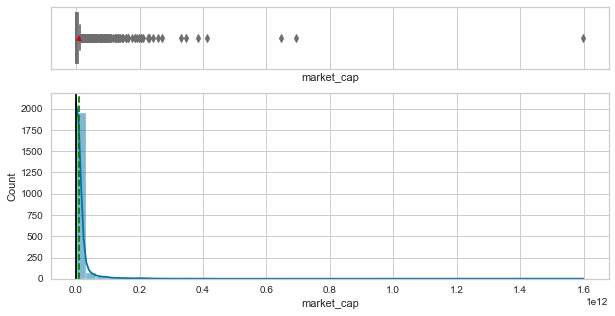

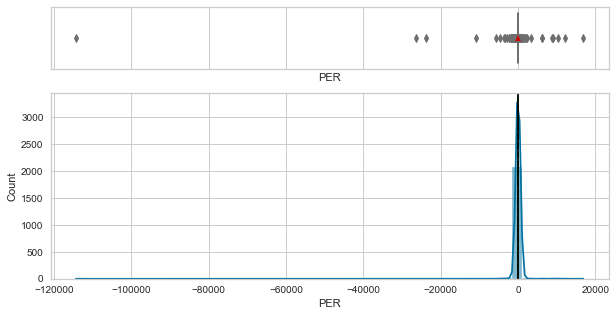

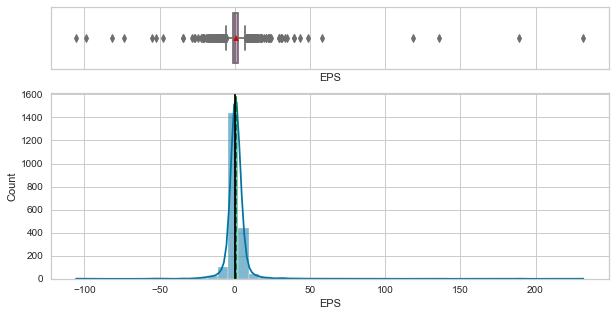

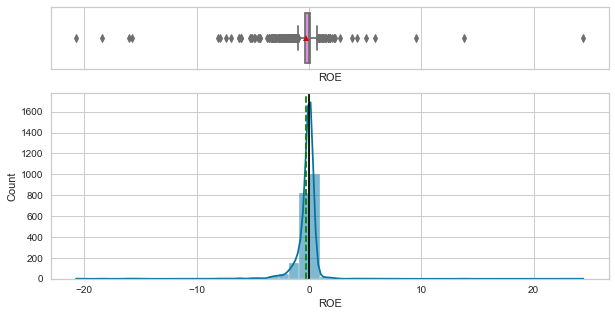

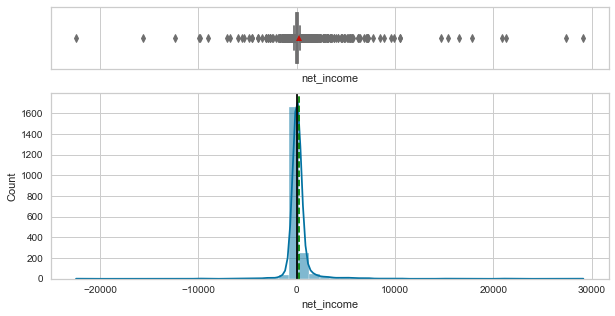

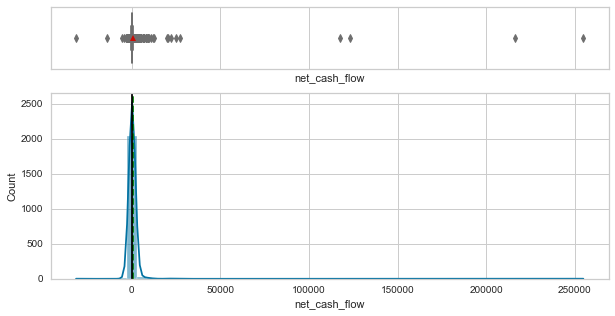

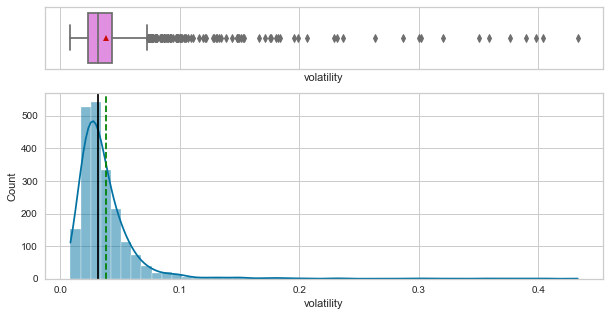

In [5]:
# see distributions of each feature

for f in features:
    histogram_boxplot(df_fin, feature=f)


## Data pre-processing

In [6]:
# remove outliers
features = ['EPS', 'net_income', 'PER', 'ROE', 'net_cash_flow']
for f in features:
    min = np.quantile(df_fin[f], 0.03)
    max = np.quantile(df_fin[f], 0.97)
    df_fin = df_fin[(df_fin[f] >= min) & (df_fin[f] <= max)]

# log transformation
df_fin['log_market_cap'] = np.log1p(df_fin['market_cap'].astype(float))

# standardization
features = ['log_market_cap', 'volatility', 'EPS',
            'PER', 'ROE', 'net_cash_flow', 'net_income']
sc = StandardScaler()
scaled = sc.fit_transform(df_fin[features])
df_fin_scaled = pd.DataFrame(scaled, columns=features)

In [7]:
df_fin_scaled

,log_market_cap,volatility,EPS,PER,ROE,net_cash_flow,net_income
0,1.350913,-0.801856,1.972090,0.233090,0.549405,-0.274506,1.762866
1,0.647436,-0.265045,0.904041,0.274561,0.603252,-0.546514,0.463912
2,1.048325,-0.624144,3.394870,0.217865,0.866029,0.836230,1.159406
3,-0.236735,-0.565566,-0.056046,0.474763,0.437401,-0.458508,-0.182397
4,1.958741,-0.831823,1.266484,0.677488,0.700178,3.235904,2.932531
...,...,...,...,...,...,...,...
1527,-0.618877,0.383201,-0.198709,0.917394,0.374938,-0.432731,-0.221945
1528,-1.933924,-0.024641,-1.085536,-0.605781,0.387861,-0.350953,-0.186166
1529,-1.696112,1.009876,-2.022489,-0.158586,-0.566321,-0.459440,-0.398194
1530,-0.785005,-0.027710,0.152166,0.536295,0.816489,-0.483233,-0.201951


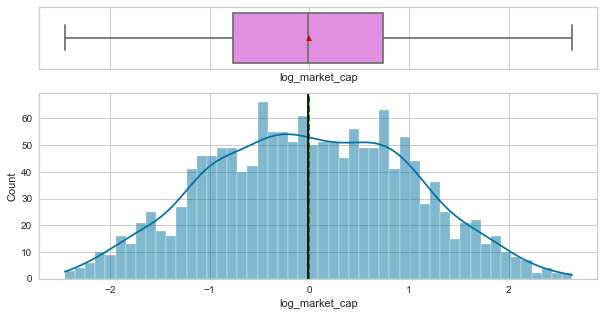

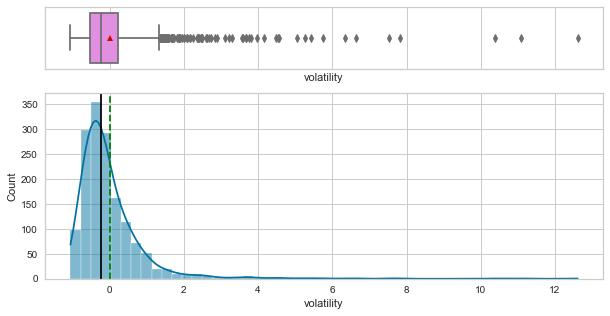

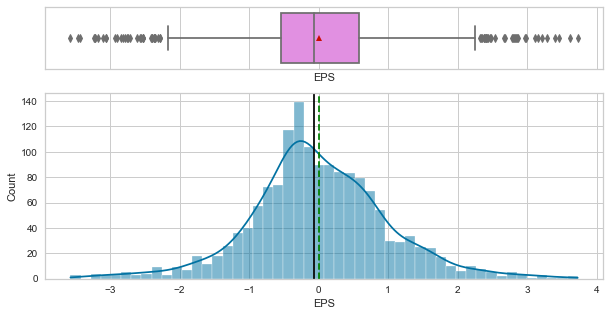

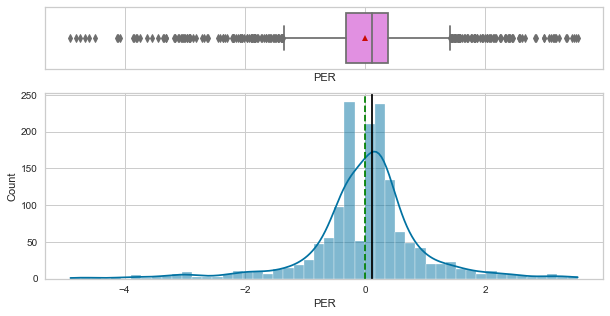

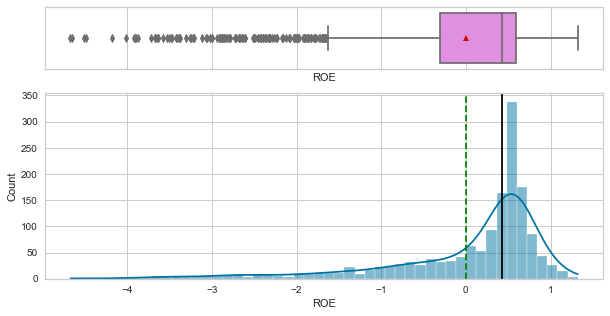

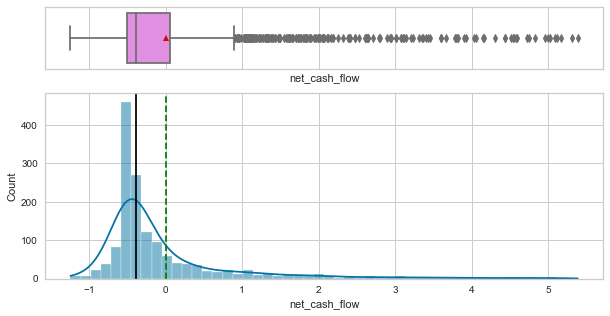

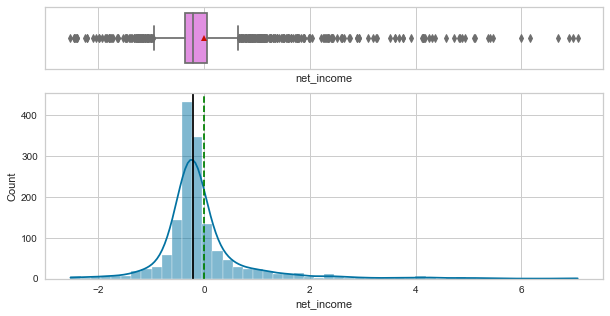

In [8]:
# see distributions of each feature

for f in features:
    histogram_boxplot(df_fin_scaled, f)

# 2. Clustering

## Silhouette Analysis for Choosing k

In [9]:
def Silhouette_analysis(df):
    """
    This is a function for Silhouette analysis using k-means model
    :df: dataframe
    """
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    silhouette_avg = []

    for k in range_n_clusters:

        # initialise kmeans
        kmeans = KMeans(n_clusters=k, random_state=2022).fit(df)
        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg.append(silhouette_score(df, cluster_labels))

    plt.plot(range_n_clusters, silhouette_avg, 'bx-')
    plt.xlabel('number of clusters, K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis', fontsize=20)
    plt.show()



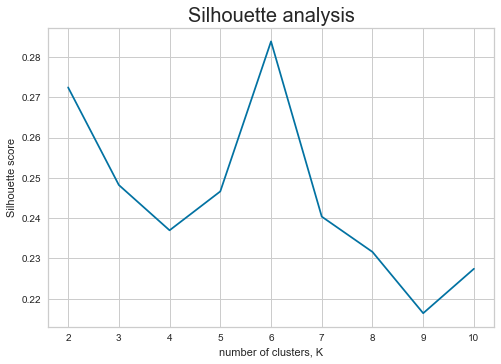

In [10]:
# Silhouette analysis to choose optimal k

Silhouette_analysis(df_fin_scaled)

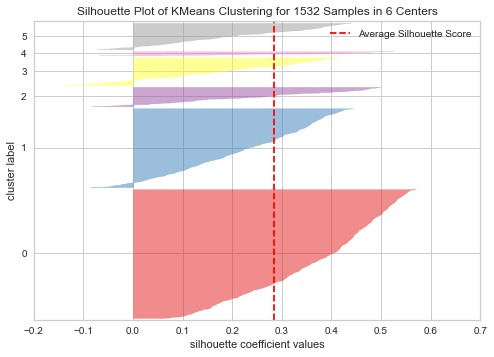

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1532 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
# visualize Silhouette scores with k-means model

num_clusters = 6

visualizer = SilhouetteVisualizer(
    KMeans(num_clusters, random_state=2022)).fit(df_fin_scaled)
visualizer.show()

## Run model

In [12]:
# fit clustering model
model = KMeans(n_clusters=num_clusters,
                random_state=2022).fit(df_fin_scaled)

# print out scores
print('Silhouette score: ',
      round(metrics.silhouette_score(df_fin_scaled, model.labels_, metric='euclidean'), 3))
print('Davies-Bouldin score: ',
      round(davies_bouldin_score(df_fin_scaled, model.labels_), 3))

# add cluster labels to data
df_fin_scaled['cluster'] = model.labels_


Silhouette score:  0.284
Davies-Bouldin score:  1.203


In [13]:
def sort_cluster_numbers(df, feature):
    """
    This is a function to sort cluster labels by a feature
    :df: dataframe
    :feature: a feature you want to sort by
    """

    as_is_list = df.groupby('cluster').median()[feature].sort_values(ascending=False).keys()
    to_be_list = range(1, num_clusters+1)

    df['cluster'] = df['cluster'].replace(dict(zip(as_is_list, to_be_list)))

In [14]:
# sort cluster labels by 'log_market_cap' for later convenience of analysis
# e.g., cluster 1 has the highest mean of 'log_market_cap'

sort_cluster_numbers(df_fin_scaled, feature='log_market_cap')

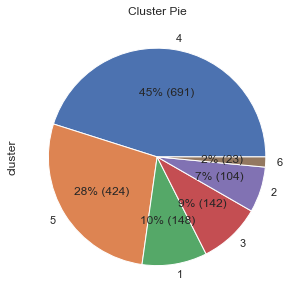

In [15]:
# plot pie chart to see cluster size 
# e.g., cluster 5 has 424 stocks and it takes 28% of all

sns.set()
counts = df_fin_scaled['cluster'].value_counts()
counts.plot(kind='pie', title='Cluster Pie', figsize=[5, 5],
            autopct=lambda p: '{:.0f}% ({:.0f})'.format(p, (p/100)*counts.sum()))
plt.show()


# 3. Clustering results

## scatterplot

In [16]:
def plot_scatterplot(df, features):
    """
    This is a function for scatterplot
    :df: dataframe
    :features: a list of features where you want to see distribtions
    """

    if len(features) == 2:
        g = sns.relplot(
            data=df, y=df[features[0]], x=df[features[1]], hue="cluster",  palette='gist_rainbow')  
        g.fig.suptitle("Clustering result with 2 features", fontsize=20)
        g.fig.subplots_adjust(top=0.9)

    elif len(features) == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        g = ax.scatter(df[features[0]], df[features[1]],
                       df[features[2]], c=df['cluster'], cmap='gist_rainbow')  
        ax.set_title('Clustering result with 3 features', fontsize=20)
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        legend = ax.legend(*g.legend_elements(), loc="center right",
                           title="cluster", borderaxespad=-8, ncol=1)
        ax.add_artist(legend)
    else:
        print('you can plot only 2 or 3 features')


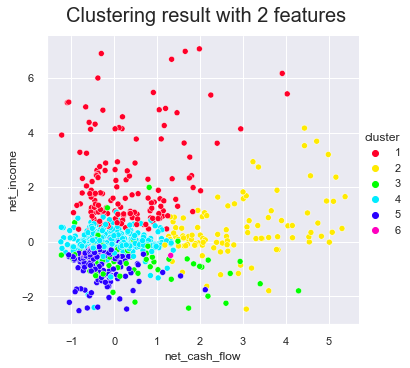

In [17]:
# clustering result with 2 features

plot_scatterplot(df_fin_scaled, features=['net_income', 'net_cash_flow'])

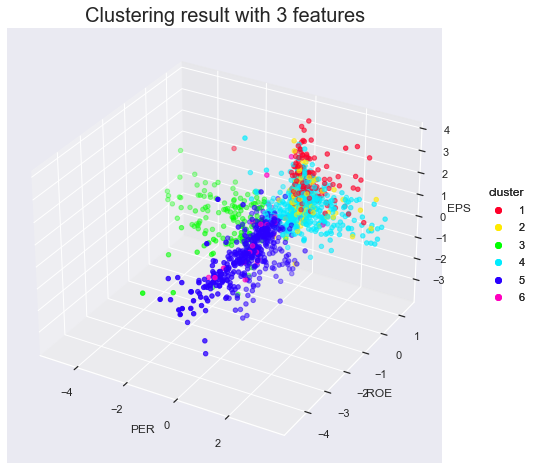

In [18]:
# clustering result with 3 features

plot_scatterplot(df_fin_scaled, features=['PER', 'ROE', 'EPS'])

In [19]:
def TSNE_2D(df):
    """
    This is a function for dimensionality reduction using TSNE
    :df: dataframe
    :return: a dataframe whose dimensionality is reduced to 2
    """

    tsne = TSNE(n_components=2, random_state=2)

    stocks = df.drop(columns=['cluster'])
    stocks_tsne = tsne.fit_transform(stocks)
    stocks_tsne_df = pd.DataFrame(
        stocks_tsne, columns=['t-SNE feature 1', 't-SNE feature 2'])
    stocks_tsne_df['cluster'] = list(df['cluster'])

    return stocks_tsne_df

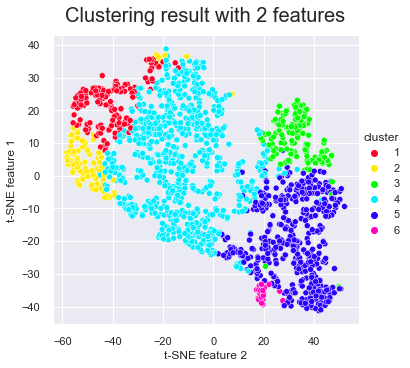

In [20]:
# clustering result with 2 TSNE features

df_TSNE_2D = TSNE_2D(df_fin_scaled)
plot_scatterplot(df_TSNE_2D, features=['t-SNE feature 1', 't-SNE feature 2'])


# 4. Analysis

## Names of firms in cluster

In [21]:
def largest_firms(df, feature):
    """
    This is a function for listing five most popular firms in cluster
    :df: dataframe
    :feature: a feature you want to sort by
    :return: dataframe with names of largest firms with feature
    """

    name_dict = {}

    k = len(df['cluster'].unique())
    for i in range(1, k+1):
        df_cluster = df[df['cluster'] == i]
        df_cluster = df_cluster.sort_values(feature, ascending=False)
        name_dict['cluster_{}'.format(i)] = df_cluster['name'][:5].tolist()

    return pd.DataFrame(name_dict, index=range(1, 6))

In [22]:
# add cluster labels to data
df_fin['cluster'] = list(df_fin_scaled['cluster'])

# list five largest firms with 'market_cap' in cluster
df_fin_names = largest_firms(df_fin, feature='market_cap')
df_fin_names


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
1,INTUITIVE SURGICAL INC,FIDELITY NATIONAL INFO SVCS,PINTEREST INC,DOMINION ENERGY INC,BRIDGEBIO PHARMA INC,ARCTURUS THERAPETCS HOLD INC
2,FISERV INC,KRAFT HEINZ CO,SEAGEN INC,ZIMMER BIOMET HOLDINGS INC,INVITAE CORP,ASSEMBLY BIOSCIENCES INC
3,DUKE ENERGY CORP,MARRIOTT INTL INC,ZENDESK INC,WILLIAMS COS INC,NOVAVAX INC,CHINA AUTOMOTIVE SYSTEMS INC
4,GLOBAL PAYMENTS INC,IQVIA HOLDINGS INC,AVALARA INC,ROLLINS INC,TG THERAPEUTICS INC,HEAT BIOLOGICS INC
5,NORFOLK SOUTHERN CORP,KINDER MORGAN INC,SAREPTA THERAPEUTICS INC,AES CORP (THE),PTC THERAPEUTICS INC,WESTWATER RESOURCES INC


## Financial properties

### Boxplot

In [23]:
def plot_boxplot(df, features):
    """
    This is a function for generating boxplot
    :df: dataframe
    :features: a list of features where you want to see distributions 
    """

    n_features = len(features)

    fig, axes = plt.subplots(1, n_features, figsize=(25, 5))
    for i in range(n_features):
        feature = df[features].columns[i]
        sns.boxplot(x="cluster", y=feature, data=df, ax=axes[i])
        axes[i].set_title("{}".format(feature), fontsize=15)
        axes[i].set_ylabel('')
    plt.show()

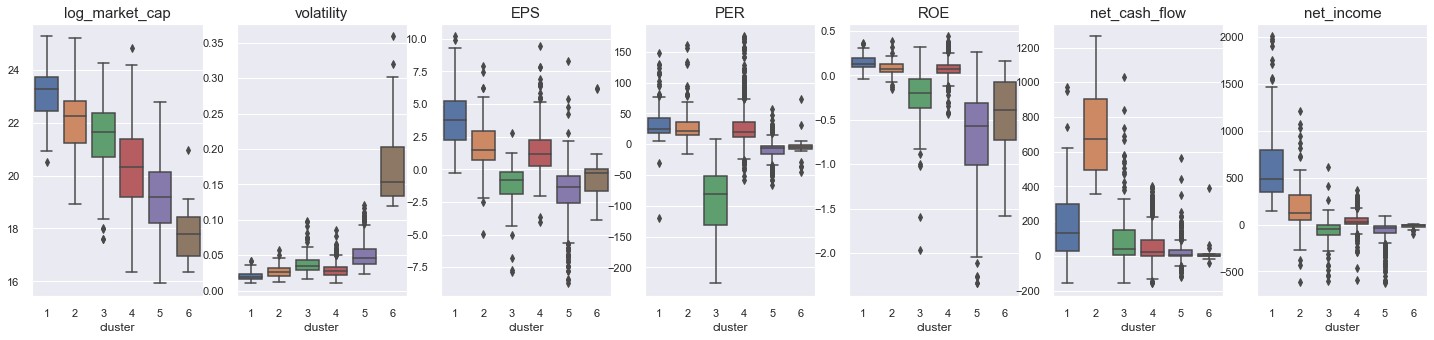

In [24]:
# plot boxplot of features

plot_boxplot(df_fin, features=['log_market_cap', 'volatility', 'EPS',
                               'PER', 'ROE', 'net_cash_flow', 'net_income'])


### Histogram

In [25]:
def plot_histogram(df, features):
    """
    This is a function for generating histogram
    :df: dataframe 
    :features: a list of features where you want to see distributions 
    """
    for i in range(len(features)):
        g = sns.FacetGrid(df, col='cluster')
        g.map_dataframe(sns.histplot, x=features[i], bins=30)


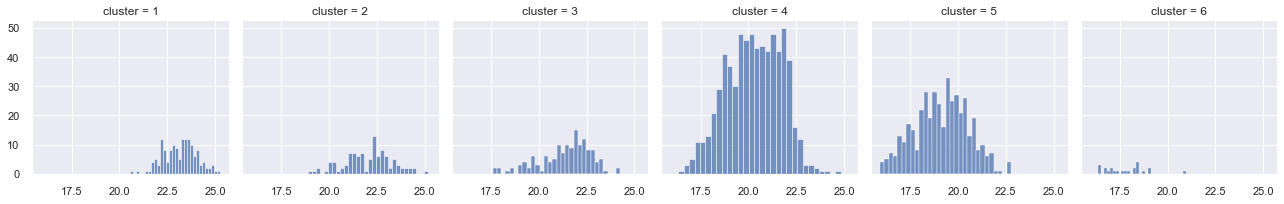

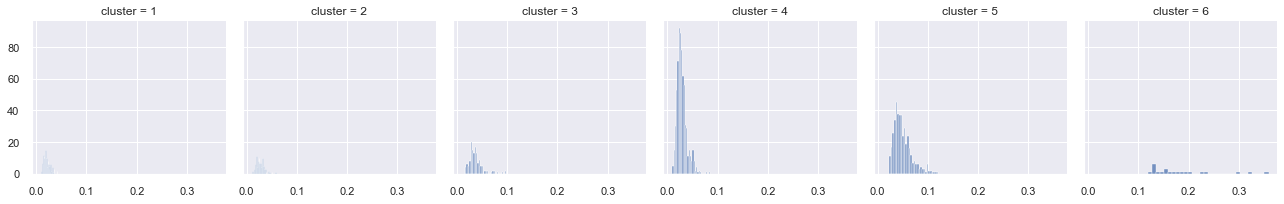

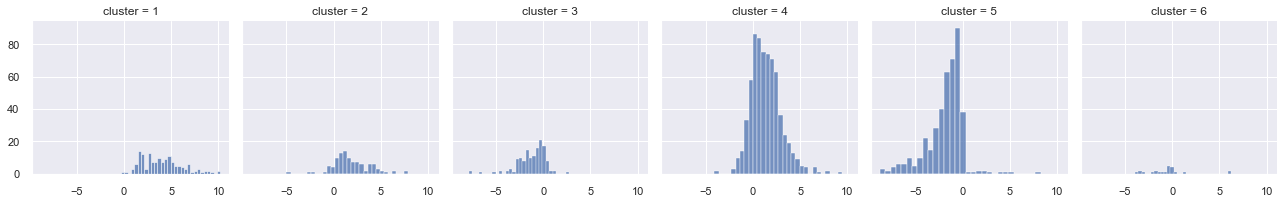

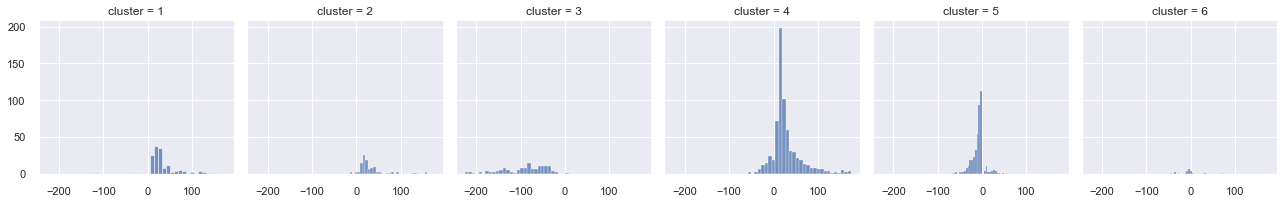

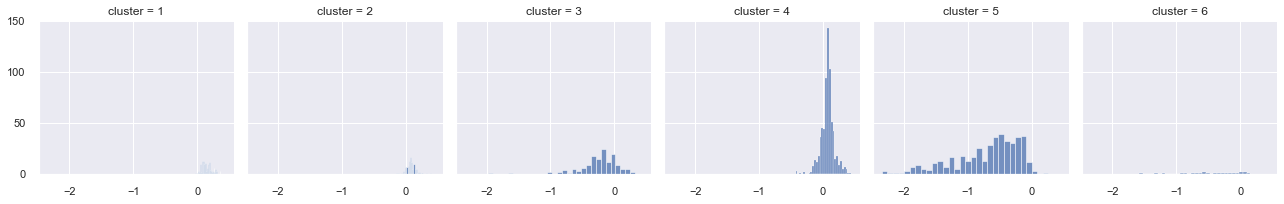

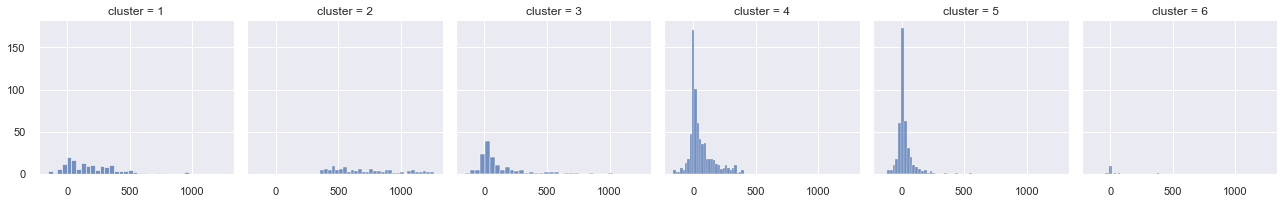

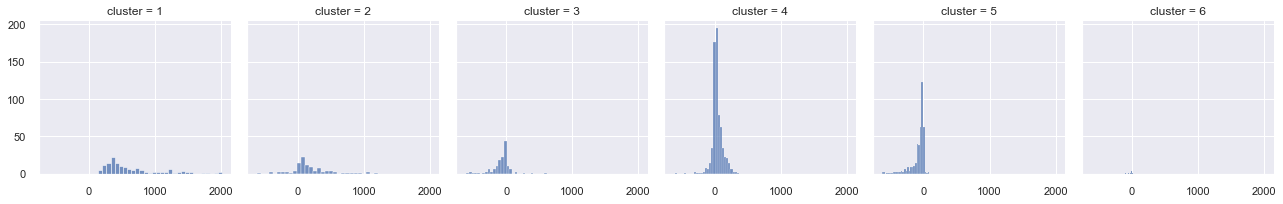

In [26]:
# plot histogram

plot_histogram(df_fin, features=['log_market_cap', 'volatility', 'EPS',
                                 'PER', 'ROE', 'net_cash_flow', 'net_income'])

### Mean table

In [27]:
def plot_mean_table(df, features):
    """
    This is a function for generating mean table
    :df: dataframe
    :features: a list of features where you want to see mean values
    """

    df_copied = df.copy()
    df_copied = df_copied[features+['cluster']]

    # calculate mean values for each cluster
    df_table = df_copied.groupby('cluster').mean()

    # color dataframe
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    df_table = df_table.style.background_gradient(cmap=cm)
    display(df_table)


In [28]:
plot_mean_table(df_fin, features=['log_market_cap', 'volatility', 'EPS',
                                  'PER', 'ROE', 'net_cash_flow', 'net_income'])

,log_market_cap,volatility,EPS,PER,ROE,net_cash_flow,net_income
cluster,,,,,,,
1,23.143487,0.020301,4.041689,33.972872,0.149885,176.990230,655.284770
2,22.059823,0.026975,1.913433,31.048798,0.077894,717.509567,193.128269
3,21.408351,0.038003,-1.224718,-91.481338,-0.248669,113.574099,-71.282655
4,20.270595,0.029023,1.375094,28.247340,0.073624,57.531339,39.433779
5,19.140726,0.050010,-1.826705,-9.228061,-0.707828,21.716849,-79.047538
6,17.812397,0.182299,-0.408696,-4.603261,-0.472870,20.841652,-18.697435


## Market behavior

In [40]:
def get_corr_and_return(df_in):
    """
    This is a function for calculating 
    (1) return correlations and (2) mean and standard deviation of returns over 6 months (Jan 2021 ~ Jul 2021)

    :df_in: dataframe
    :return avg_intra_list: a list of average intra correlations of each cluster
    :return avg_inter_list: a list of average inter correlations between clusters
    :return mu: mean of daily log returns of each cluster
    :return Sigma: a variance-covariance matrix between clusters
    """

    df = df_in.copy()

    # create a dictionary (key: cluster number, item: tic list)
    tic_list_dict = {}
    for key, value in df.groupby('cluster'):
        tic_list_dict[key] = list(value['tic'])

    # filter stocks
    daily_price = df_daily[df_daily['tic'].isin(list(df['tic']))].sort_values('datadate')

    # calculate log returns from daily close price
    n_clusters = len(df['cluster'].unique())
    daily_logret_dict = {}
    for k in range(1, n_clusters+1):
        # daily close price (for each cluster)
        prices = daily_price[daily_price['tic'].isin(tic_list_dict[k])]
        # daily close price (for each stock)
        df_close_dict = {}
        for tic in tic_list_dict[k]:
            price = prices[prices['tic'] == tic]['prccd'].values
            if len(price) == 126:
                df_close_dict[tic] = price
        df_close = pd.DataFrame.from_dict(df_close_dict)
        # log return transformation
        df_logret = np.log(df_close/df_close.shift(1))
        df_logret = df_logret.drop(0) # drop NaN value at the first day 
        daily_logret_dict[k] = df_logret

    # calculate average intra-correlations
    avg_intra_list = []
    for k in range(1, n_clusters+1):
        df_corr = daily_logret_dict[k].corr()
        df_corr['sum'] = df_corr.sum(axis=1) - 1
        df_corr['avg'] = df_corr['sum']/(len(df_corr)-1)
        avg_intra_list.append(df_corr['avg'].mean())

    # calculate average inter-correlations
    daily_logret_corr = pd.concat(daily_logret_dict, axis=1).corr()
    avg_inter_list = []
    for i in range(1, n_clusters):
        for j in range(i+1, n_clusters+1):
            rectangle = daily_logret_corr.loc[i, j]
            avg = np.nanmean(rectangle)
            avg_inter_list.append(avg)

    # calculate mean and covariance of returns between clusters (for 6 months)
    avg_logret_dict = {}
    for k in range(1, n_clusters+1):
        avg_logret_dict['cluster_{}'.format(
            k)] = daily_logret_dict[k].mean(axis=1)
    avg_logret_df = pd.DataFrame(avg_logret_dict)

    mu = avg_logret_df.mean() * len(avg_logret_df)  # annualization (126 days)
    Sigma = avg_logret_df.cov() * len(avg_logret_df)  # annualization (126 days)

    return avg_intra_list, avg_inter_list, mu, Sigma


In [41]:
# get correlations and returns

avg_intra_list, avg_inter_list, mu, Sigma = get_corr_and_return(df_fin)

### Return correlations

In [31]:
def plot_corr_table(avg_intra_list, avg_inter_list):
    """
    This is a function to plot correlations table
    :avg_intra_list: a list of average intra correlations of each cluster
    :avg_inter_list: a list of average intra correlations of between clusters
    """

    # some functions for plot
    cmap = copy.copy(plt.cm.get_cmap("Blues"))
    cmap.set_under("white")
    def color_nan_white(val):
        """Color the nan text white"""
        if np.isnan(val):
            return 'color: white'
    def color_nan_white_background(val):
        """Color the nan cell background white"""
        if np.isnan(val):
            return 'background-color: white'
    
    # create a matrix whose diagonal elements are average intra-correlations and off-diagonal elements are average inter-correlations
    n_clusters = len(avg_intra_list)
    corr_matrix = np.zeros((n_clusters, n_clusters))
    np.fill_diagonal(corr_matrix, avg_intra_list)

    indices = np.triu_indices(n_clusters, 1)
    corr_matrix[indices] = avg_inter_list
    corr_matrix = pd.DataFrame(corr_matrix)

    # fill 0s with NaNs
    corr_matrix = corr_matrix.replace(0, np.nan)
    # modify names
    corr_matrix.columns = ['Cluster_{}'.format(i+1) for i in range(n_clusters)]
    corr_matrix.index = ['Cluster_{}'.format(i+1) for i in range(n_clusters)]
    # color dataframe
    global cm
    cm = sns.light_palette("gray", as_cmap=True)
    corr_matrix = corr_matrix.style.background_gradient(cmap=cm).applymap(
        lambda x: color_nan_white(x)).applymap(lambda x: color_nan_white_background(x))
    display(corr_matrix)

In [32]:
# plot correlations table where
# diagonal elements are average intra-correlations
# off-diagonal elements are average inter-correlations

plot_corr_table(avg_intra_list, avg_inter_list)

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6
Cluster_1,0.262514,0.295900,0.136110,0.219293,0.111795,0.070901
Cluster_2,nan,0.417184,0.160402,0.306824,0.155933,0.092798
Cluster_3,nan,nan,0.249587,0.154893,0.190726,0.187356
Cluster_4,nan,nan,nan,0.240692,0.142497,0.100783
Cluster_5,nan,nan,nan,nan,0.177150,0.183045
Cluster_6,nan,nan,nan,nan,nan,0.223911


### Return and Risk

In [36]:
def plot_return_and_risk(mu, Sigma):
    """
    This is a function to create a scatterplot of mean and standard deviation of returns of clusters
    """

    return_df = pd.DataFrame(
        {'Mean': mu.values, 'Standard Deviation': np.diag(Sigma)}, index=mu.index)
    return_df = return_df.reset_index()

    g = sns.lmplot(
        data=return_df,
        x="Standard Deviation", y="Mean", hue="index",
        height=5,
        scatter_kws={"s": 200},
        ci=None, fit_reg=False  # turn off the shade and line
    )

    g.set_axis_labels("Standard Deviation", "Mean")
    plt.title('Return and Risk', fontsize=20)
    plt.ylim(-0, 0.3)

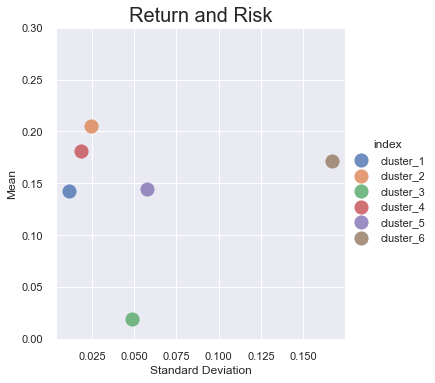

In [37]:
plot_return_and_risk(mu, Sigma)